In [1]:
import os
import sys
import inspect
from matplotlib import pyplot as plt
import numpy as np
import pickle

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)

In [2]:


file = open("../parsed_data.pkl", 'rb')
corrs = pickle.load(file)
file.close()

file = open("../parsed_data_nm2_gender.pkl", 'rb')
pcorrs = pickle.load(file)
file.close()

In [3]:
use_nm2 = True

if use_nm2:
    matricies = [np.array(pc['adjacency']).flatten() for pc in pcorrs]
    y =  [pc['gender'] for pc in pcorrs]
else:
    matricies = [np.array(pc['adjustency_matrix']).flatten() for pc in corrs]
    y =  [pc['gender'] for pc in corrs]

In [4]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(matricies)

# Explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {np.sum(explained_var_ratio)*100}%" )


Explained Variance Ratio: 22.44396008163617%


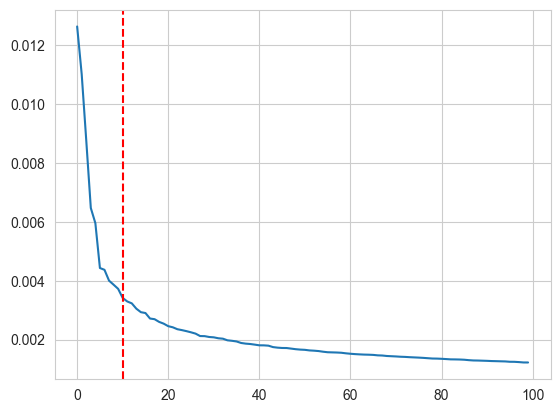

In [5]:
plt.plot(explained_var_ratio)
plt.axvline(10, color = "red", ls = "--")

In [6]:
pca = PCA(n_components=10)
X_pca = pca.fit_transform(matricies)


Accuracy: 0.9054726368159204


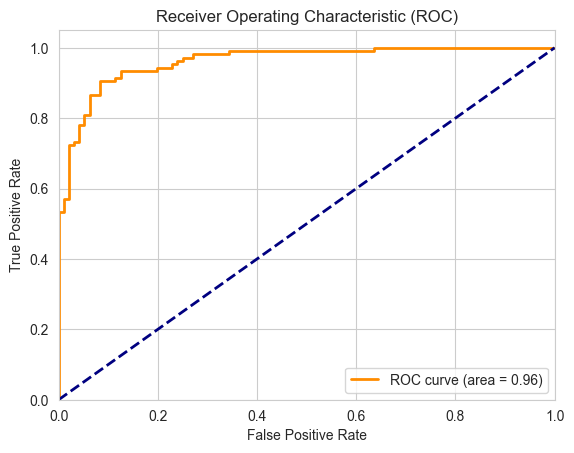

In [7]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb


# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Define the XGBoost model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Fit the model on the training data
model.fit(X_train, y_train)


y_prob = model.predict_proba(X_test)[:, 1]
y_pred_binary = model.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

(array([469.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 534.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

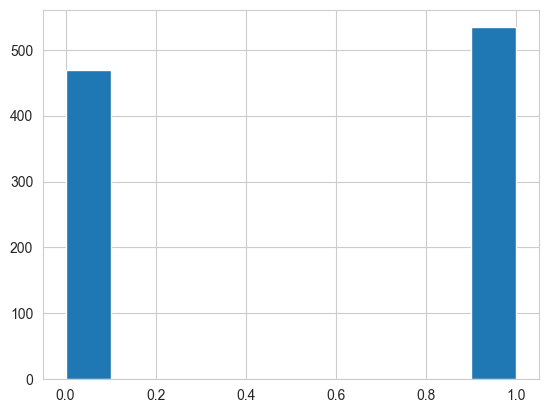

In [8]:
plt.hist(y)

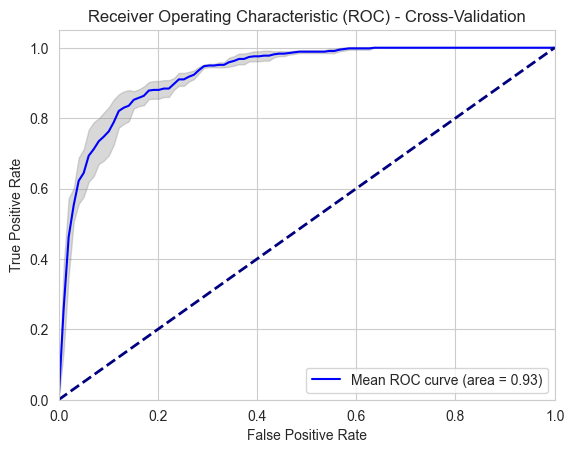

In [9]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load your dataset or generate sample data
# X: Features, y: Labels
# Replace this with your data loading process
X = X_pca
y = np.array(y)

# Define the XGBoost model
model = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.1,
    n_estimators=100,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store ROC curve data for each fold
mean_fpr = np.linspace(0, 1, 100)
tpr_list = []

# Perform cross-validation
for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict probabilities for the positive class (class 1)
    y_prob = model.predict_proba(X_test)[:, 1]

    # Calculate ROC curve for this fold
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    tpr_list.append(np.interp(mean_fpr, fpr, tpr))
    tpr_list[-1][0] = 0.0

# Calculate mean and standard deviation of ROC curve data across folds
mean_tpr = np.mean(tpr_list, axis=0)
std_tpr = np.std(tpr_list, axis=0)

# Calculate AUC for the mean ROC curve
roc_auc = auc(mean_fpr, mean_tpr)

# Plot mean ROC curve with shaded area for standard deviation
plt.figure()
plt.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC curve (area = %0.2f)' % roc_auc)
plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.3)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Cross-Validation')
plt.legend(loc="lower right")
plt.show()


# Analysis of PCA-transformed variables

In [10]:
data = pd.DataFrame(X)
input_cols = data.columns
target_col = 'target'
data[target_col] = y

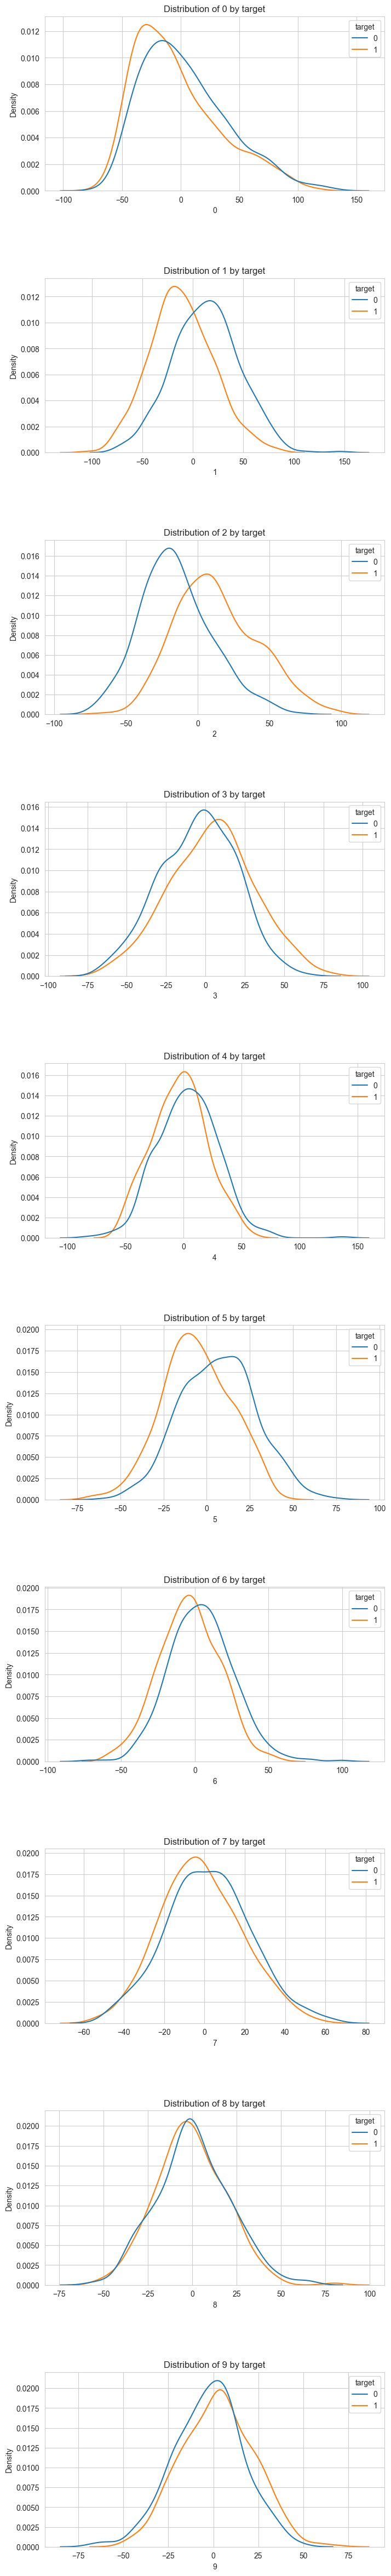

In [11]:
import seaborn as sns
# Set up the figure and axes
num_rows = len(input_cols)
fig, axes = plt.subplots(num_rows, 1, figsize=(8, num_rows * 6))
fig.subplots_adjust(hspace=0.5)

# Loop through each input column and create normalized density plots
for i, col in enumerate(input_cols):
    ax = axes[i]
    # sns.histplot(data=data, x=col, hue=target_col, common_norm=False, ax=ax)
    sns.kdeplot(data=data, x=col, hue=target_col, common_norm=False, ax=ax)
    ax.set_title(f'Distribution of {col} by {target_col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')

plt.show()